# Pronostico de aperturas de muestreo en Sondeos electricos Verticales

queremos comprobar si es posible generar predicciones de aperturas que nos permitas identificar de mejor manera los limites o contrastes de unidades geoelectricas reistivas, y compararlo con resultados conta el metodo de muestreo comunmente empleado.

## paso cero

integracion de datos iniciales y librerias que se emplearan

## paso 1

Para ello emplearemso datos conocidos de resultados de muestreos integrando los espesores y resitividades de las unidades geolectricas del medio, identificamos sus estadisticos basicos y la distribucion a la que mejor se ajustan

## paso 2

Se procede a generar variaciones de modelos tomando como base la distribucion de ajuste de cada sitio de estudio, apartir de la cual se generaran variacines de espesores manteniendo la relacion de la distribucion a la cual se ajustan los valores de los modelos de c ada sitio, asi como a su desviacion estandar.

## paso 3 

Una ves generadas las variaciones de modelos se generan registros independientes para cada sitio, de manera que obtengamos valores de resitividad mediante PyGIMLI para cada sitio,

## paso 4

Con este conjunto de datos se procede a realizar el entrenamiento y comprobacion de cada sitio empleando los valores de adquisicion reales

## paso 5

se realiza estaddsitico comparativo de los resultados mas destacados


### Paso Cero

integramos las librerias que emplearemos y los datos apartir de los cuales se desarrolla el proyecto

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pygimli as pg # Muy importante tener PyGIMLi instalado
from pygimli.physics import VESManager
from pygimli.physics.ves import VESManager  

import scipy.stats as stats
from scipy.stats import norm, weibull_min, gamma

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from typing import Dict, Any, List, Tuple, Optional

import joblib  # Para guardar y cargar modelos



In [2]:
# primer conjunto de datos empleado, 
#df = pd.read_csv("DATOS/modelos_sinteticos-SEV.csv")

#datos corregidos
df = pd.read_csv("DATOS/Modelos-caracterizados-completo.csv")

In [3]:
pd.set_option('display.max_columns', None)  # Esto asegura que se muestren todas las columnas
pd.set_option('display.max_rows', 10)  # Esto asegura que se muestren un número definido de filas
print(df.head(25))  # Muestra las primeras 10 filas del DataFrame

          Modelo  Sitio  Espesor_1  Espesor_2  Espesor_3  Resistividad_1  \
0     S1-LN-EBSA      1        6.1      60.70     131.30          150.00   
1     S2-LN-EBSA      1        6.4      78.47     113.53          196.01   
2     S3-LN-EBSA      1        6.0      70.00     122.00          437.20   
3      S1-AMEBSA      2        2.4       8.50      45.50           56.60   
4      S2-AMEBSA      2        1.3       4.50      66.00           56.00   
..           ...    ...        ...        ...        ...             ...   
20    S3-EGH-OLV      7       40.0      20.00     138.00          750.00   
21  S1-ZR-P-EBSA      8        3.5      12.00      44.50            3.00   
22  S2-ZR-P-EBSA      8        4.0       6.00      56.00          350.00   
23  S3-ZR-P-EBSA      8        8.0      37.00      20.00          250.00   
24  S4-ZR-P-EBSA      8        5.6      13.00      20.00         1300.00   

    Resistividad_2  Resistividad_3  Resistividad_4  AB2_1  AB2_2  AB2_3  \
0           

In [4]:
df.describe()

,Sitio,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,AB2_4,AB2_5,AB2_6,AB2_7,AB2_8,AB2_9,AB2_10,AB2_11,AB2_12,AB2_13,AB2_14,AB2_15,AB2_16,AB2_17,AB2_18,AB2_19,AB2_20,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,25.000000,25.000000,25.000000,23.000000,25.000000,25.000000,25.00000,23.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,4.440000,5.190400,22.446800,67.236087,183.283200,711.214400,1841.18240,2222.542261,1.120000,3.000000,5.320000,7.120000,9.400000,11.720000,14.400000,16.960000,20.44000,23.880000,26.680000,31.64000,36.840000,40.680000,45.160000,50.120000,54.000000,60.360000,67.360000,73.12000,79.240000,87.04000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,2.467793,7.579532,19.795223,45.085015,293.547888,1033.131992,2425.93679,3046.763130,0.331662,2.327373,4.028234,5.932397,7.735201,9.576534,11.302655,13.001538,14.50023,16.032051,17.969233,20.38766,22.415917,25.102656,27.614429,30.004611,32.900101,35.807215,40.004041,44.59103,47.625518,53.29828,61.397258,67.619031,71.056011,76.897508,81.246497,86.544247,92.899803,102.919062
min,1.000000,0.700000,4.500000,20.000000,1.000000,1.000000,32.50000,39.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,8.000000,10.000000,12.00000,13.000000,14.000000,15.00000,16.000000,18.000000,20.000000,22.000000,23.000000,24.000000,25.000000,28.00000,30.000000,32.00000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,2.000000,2.360000,9.000000,41.800000,21.800000,45.000000,85.00000,111.000000,1.000000,2.000000,3.000000,4.000000,5.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,22.00000,25.000000,28.000000,30.000000,32.000000,35.000000,43.000000,48.000000,50.00000,54.000000,58.00000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,4.000000,3.000000,15.800000,52.700000,56.600000,100.000000,1271.40000,1216.440000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,23.00000,28.000000,30.000000,33.000000,38.000000,40.000000,44.000000,48.000000,50.00000,55.000000,60.00000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,7.000000,5.600000,26.000000,73.000000,196.010000,1300.000000,2300.00000,2940.000000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,24.00000,30.000000,30.000000,34.000000,38.000000,40.000000,50.000000,55.000000,60.00000,65.000000,70.00000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,8.000000,40.000000,78.470000,204.000000,1300.000000,3350.000000,11000.00000,13200.000000,2.000000,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.00000,90.000000,100.000000,110.00000,120.000000,130.000000,140.000000,150.000000,160.000000,170.000000,180.000000,190.00000,200.000000,210.00000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000


### Paso 1

se generan los estadisticos basicos y la distribucion que mjor se ajusta a cada sitio

   Sitio Mejor_Distribucion  \
0      1               norm   
1      2        weibull_min   
2      3               norm   
3      4               norm   
4      5        weibull_min   
5      6        weibull_min   
6      7              gamma   
7      8        weibull_min   

                                          Parametros   KS_stat   p_value  
0            (66.05555555555556, 47.841084182974676)  0.227126  0.662627  
1  (0.30435951866513944, 1.2999999999999998, 25.3...  0.264685  0.203960  
2                         (15.0, 11.510864433221338)  0.330368  0.672065  
3                         (20.0, 18.450956012569588)  0.226881  0.663870  
4  (0.5002639226424053, 0.6999999999999998, 10.30...  0.229222  0.651996  
5  (0.6960698150189448, 2.3599999999999994, 27.56...  0.213594  0.897464  
6  (0.7065440219344926, 2.999999999999999, 54.370...  0.184266  0.868458  
7  (0.5799705282246079, 3.4999999999999996, 14.46...  0.120975  0.985680  


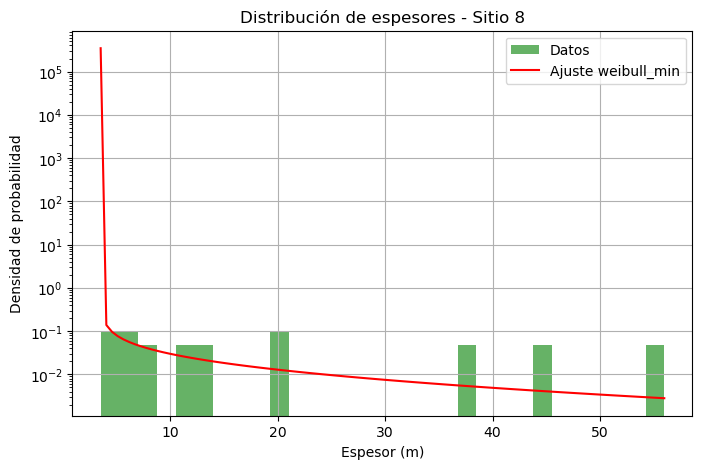

In [5]:


columnas_espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]
distribuciones = [stats.norm, stats.lognorm, stats.gamma, stats.expon, stats.weibull_min]
resultados_por_sitio = []

for sitio, datos in df.groupby("Sitio"):
    todos_los_espesores = pd.concat([datos[col] for col in columnas_espesores], ignore_index=True).dropna()
    
    resultados = {}
    for dist in distribuciones:
        params = dist.fit(todos_los_espesores)
        D, p_value = stats.kstest(todos_los_espesores, dist.cdf, args=params)
        resultados[dist.name] = {'params': params, 'KS_stat': D, 'p_value': p_value}
    
    mejor_ajuste = sorted(resultados.items(), key=lambda x: x[1]['KS_stat'])[0]
    
    resultados_por_sitio.append({
        "Sitio": sitio,
        "Mejor_Distribucion": mejor_ajuste[0],  # Corrected index
        "Parametros": mejor_ajuste[1]['params'],
        "KS_stat": mejor_ajuste[1]['KS_stat'],
        "p_value": mejor_ajuste[1]['p_value']
    })

# Convertir resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_por_sitio)
print(resultados_df)

# Graficar la mejor distribución para un sitio de ejemplo
sitio_ejemplo = df["Sitio"].unique()[7]
datos_ejemplo = df[df["Sitio"] == sitio_ejemplo][columnas_espesores].values.flatten()
datos_ejemplo = datos_ejemplo[~np.isnan(datos_ejemplo)]

mejor_dist = resultados_df[resultados_df["Sitio"] == sitio_ejemplo]["Mejor_Distribucion"].values[0]
parametros = resultados_df[resultados_df["Sitio"] == sitio_ejemplo]["Parametros"].values[0]

plt.figure(figsize=(8, 5))
plt.hist(datos_ejemplo, bins=30, density=True, alpha=0.6, color='g', label="Datos")
x = np.linspace(min(datos_ejemplo), max(datos_ejemplo), 100)
pdf_fitted = getattr(stats, mejor_dist).pdf(x, *parametros)
plt.plot(x, pdf_fitted, 'r-', label=f"Ajuste {mejor_dist}")
plt.title(f"Distribución de espesores - Sitio {sitio_ejemplo}")
plt.xlabel("Espesor (m)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.yscale('log') 
plt.grid()
plt.show()


#### Distribucion de todo el conjunto de datos

Obtenemos la distribucion a la que mejor se ajustan los datos del total de modelo sempleados, en esta etapa queremos conocer la distribucion y estadistica de los datos de inicio, a fin de recrear modelos sinteticos y poder establecer una comparacion cualitativa y cuantitativa de los datos. comparar entre los metodos de entrenamiento y poder elegir aquel que presenta la mejor respuesta

Mejor distribución: gamma
Parámetros: (0.6001346597115194, 0.6999999999999998, 49.39745715531717)
Estadístico KS: 0.07306847163784412
Valor p: 0.8035043049636843


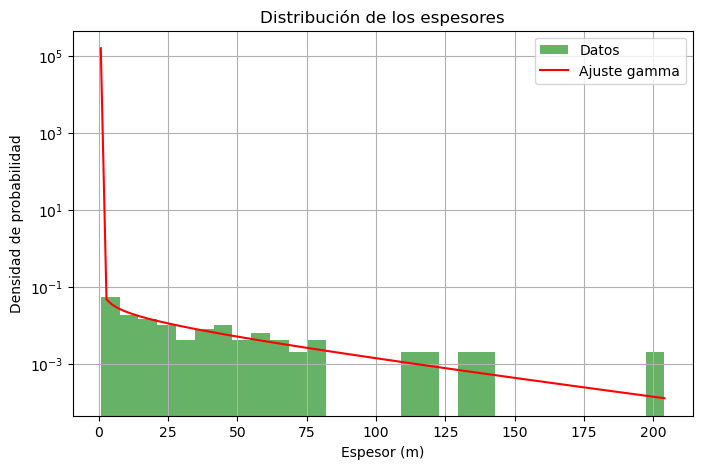

In [6]:
# Realizamos la identificacion de las distribuciones de los datos de los espesores que mejor se sjusta a los datos reales
#columnas de espesores
columnas_espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Asegúrate de incluir todas
todos_los_espesores = pd.concat([df[col] for col in columnas_espesores], ignore_index=True).dropna()

distribuciones = [stats.norm, stats.lognorm, stats.gamma, stats.expon, stats.weibull_min]
resultados = {}

# se realiza ajuste y evalucioan de  cada distribucion con los datos del espesor
for dist in distribuciones:
    params = dist.fit(todos_los_espesores)
    D, p_value = stats.kstest(todos_los_espesores, dist.cdf, args=params)
    
    resultados[dist.name] = {'params': params, 'KS_stat': D, 'p_value': p_value}

mejor_ajuste = sorted(resultados.items(), key=lambda x: x[1]['KS_stat'])[0]#Ordenar por mejor ajuste en estadístico KS

#vamos por los resultados del mejor ajuste
print("Mejor distribución:", mejor_ajuste[0])
print("Parámetros:", mejor_ajuste[1]['params'])
print("Estadístico KS:", mejor_ajuste[1]['KS_stat'])
print("Valor p:", mejor_ajuste[1]['p_value'])

plt.figure(figsize=(8, 5))
plt.hist(todos_los_espesores, bins=30, density=True, alpha=0.6, color='g', label="Datos")
x = np.linspace(min(todos_los_espesores), max(todos_los_espesores), 100)
pdf = mejor_ajuste[1]['params']
pdf_fitted = getattr(stats, mejor_ajuste[0]).pdf(x, *pdf)
plt.plot(x, pdf_fitted, 'r-', label=f"Ajuste {mejor_ajuste[0]}")
plt.title("Distribución de los espesores")
plt.xlabel("Espesor (m)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.yscale('log') 
plt.grid()
plt.show()

## paso 2

Se procede a generar variaciones de modelos tomando como base la distribucion de ajuste de cada sitio de estudio, apartir de la cual se generaran variacines de espesores manteniendo la relacion de la distribucion a la cual se ajustan los valores de los modelos de c ada sitio, asi como a su desviacion estandar.

### comprobacion de Modelado de Rha de los modelos iniciales

Modelamos la risistividad aparente de los datos apartir de los espesores y la resitividad calculada de las unidades, sesimulara un VES mediante las herramientas de la libreria PiGimli, empleada en el procesamiento e inversion de datos geofisicos, para verificar que los datos apartir de los cuales se generaran las variaciones se ejecuten correctamente, 

In [7]:
#limpieza de datos, eliminamos los registros con valores nulos Nan.. previamente se verifica pero se correo porsi acaso
df = df.dropna()

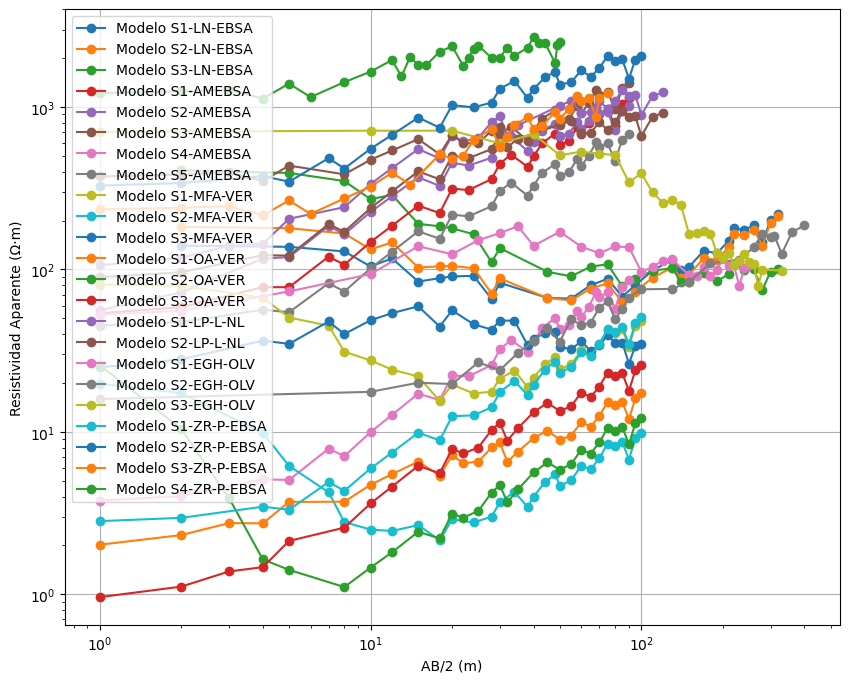

guardado 'RESULTADOS-Simulacion-Tesis-2.csv'


In [8]:

resultados = []
resistividades_aparentes = []

fig, ax = plt.subplots(figsize=(10, 8))

for _, row in df.iterrows():
    modelo_id = row["Modelo"]
    sitio_id = row["Sitio"]  # Sitio correspondiente  
    
    espesores = row.filter(like="Espesor_").dropna().astype(str).replace("∞", "").astype(float).tolist()
    resistividades = row.filter(like="Resistividad_").dropna().astype(float).tolist()

    synthModel = espesores + resistividades# modelo sintético
    
  # extraemos los valores de apertura del arreglo que se empleara en la simulación
    ab2 = row.filter(like="AB2_").dropna().astype(float).values
    
     # se procede a generar la simulacion de la respuesta geolectrica en el subsuelo y graficamos el resultado, se agrega un nivel de ruido del 9%
 #Esta línea de código ejecuta la simulación de un sondeo eléctrico vertical (SEV) utilizando el método de resistividad aparente.
    ves = VESManager()
    rhoa, err = ves.simulate(synthModel, ab2=ab2, mn2=ab2 / 3, noiseLevel=0.09, seed=1337)
    #La función simulate() genera una curva de resistividad aparente para el modelo synthModel, 
    # #usando un conjunto de espaciados de electrodos (ab2) y aplicando ruido para simular condiciones reales.

    for i in range(len(ab2)):
        resultados.append([modelo_id, sitio_id, ab2[i], rhoa[i]])
        resistividades_aparentes.append(rhoa[i])
    ax.plot(ab2, rhoa, 'o-', label=f"Modelo {modelo_id}")

df_resultados = pd.DataFrame(resultados, columns=["Modelo_ID", "Sitio_ID", "AB2", "Resistividad_Aparente"])
df_resultados.to_csv("RESULTADOS-Simulacion-Tesis-2.csv", index=False)


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("AB/2 (m)")
ax.set_ylabel("Resistividad Aparente (Ω·m)")
ax.legend()
ax.grid()
plt.show()

print("guardado 'RESULTADOS-Simulacion-Tesis-2.csv'")

In [9]:
print(df_resultados.head())

    Modelo_ID  Sitio_ID   AB2  Resistividad_Aparente
0  S1-LN-EBSA         1   2.0             140.078269
1  S1-LN-EBSA         1   5.0             137.871321
2  S1-LN-EBSA         1   8.0             129.092621
3  S1-LN-EBSA         1  10.0             104.331439
4  S1-LN-EBSA         1  12.0             117.051825


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from typing import Dict, Any, List, Tuple

# Cargar el dataset
df = pd.read_csv("RESULTADOS-Simulacion-Tesis-2.csv")#TESIS-MCD\WorkWorkWork\RESULTADOS-Simulacion-Tesis-2.csv

# Columnas de espesores (features) 
features = ["Resistividad_Aparente"]

# Variable objetivo
target = "AB2"

# Definir hiperparámetros a evaluar
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [None, 10, 20],  # Profundidad máxima
    "min_samples_split": [10, 20, 30]  # Muestras mínimas para dividir nodo
}





def grid_search_model_by_site(df: pd.DataFrame, x: List[str], y: str, model_to_use,
                              parameters_grid: Dict[str, Any], score_name: str,
                              cross_validation_parts: int) -> Dict[int, Dict]:
    """
    Realiza la búsqueda de hiperparámetros para cada sitio de manera independiente.
    """
    mejores_hiperparametros = {}

    for sitio, df_sitio in df.groupby("Sitio_ID"):  # Agrupar por Sitio
        print(f"\n🔍 Buscando mejores hiperparámetros para Sitio {sitio}...")

        # Eliminar filas con valores nulos
        df_sitio = df_sitio.dropna(subset=x + [y])

        if df_sitio.empty:
            print(f"⚠️ Sitio {sitio} no tiene datos suficientes.")
            continue

        X = df_sitio[x]
        y_values = df_sitio[y]

        grid_search = GridSearchCV(
            estimator=model_to_use,
            param_grid=parameters_grid,
            cv=cross_validation_parts,
            scoring=score_name,
            n_jobs=-1
        )
        
        grid_search.fit(X, y_values)

        # Guardamos los mejores parámetros y scores
        mejores_hiperparametros[sitio] = {
            "Mejores_Parametros": grid_search.best_params_,
            "Score_Entrenamiento": grid_search.best_score_
        }

        print(f"✅ Sitio {sitio} - Mejores parámetros: {grid_search.best_params_}")

    return mejores_hiperparametros

# Ejecutar la búsqueda de hiperparámetros por sitio
mejores_hiperparametros = grid_search_model_by_site(
    df=df,
    x=features,
    y=target,
    model_to_use=RandomForestRegressor(random_state=42),
    parameters_grid=param_grid,
    score_name="neg_mean_squared_error",
    cross_validation_parts=5
)

# Mostrar resultados
print("\n📌 Mejores hiperparámetros por sitio:")
for sitio, datos in mejores_hiperparametros.items():
    print(f"\n🔹 Sitio {sitio}")
    print(f"   Mejores Parámetros: {datos['Mejores_Parametros']}")
    print(f"   Score Entrenamiento: {datos['Score_Entrenamiento']:.4f}")



🔍 Buscando mejores hiperparámetros para Sitio 1...
✅ Sitio 1 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 2...
✅ Sitio 2 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 4...
✅ Sitio 4 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 5...
✅ Sitio 5 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 6...
✅ Sitio 6 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 7...
✅ Sitio 7 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 8...
✅ Sitio 8 - Mejores parámetros: {'max_depth': None,

In [11]:

# Cargar el dataset
df = pd.read_csv("RESULTADOS-Simulacion-Tesis-2.csv")

# Asegurar que los datos sean numéricos y positivos
df = df.apply(pd.to_numeric, errors="coerce")  # Convertir a numérico
df = df[df["Resistividad_Aparente"] > 0]  # Filtrar valores negativos

# Columnas de espesores (features)
features = ["Resistividad_Aparente"]

# Variable objetivo
target = "AB2"

# Definir hiperparámetros a evaluar
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [None, 10, 20],  # Profundidad máxima
    "min_samples_split": [10, 20, 30]  # Muestras mínimas para dividir nodo
}


def grid_search_model_by_site(df: pd.DataFrame, x: List[str], y: str, model_to_use,
                              parameters_grid: Dict[str, Any], score_name: str,
                              cross_validation_parts: int) -> Dict[int, Dict]:
    """
    Realiza la búsqueda de hiperparámetros para cada sitio de manera independiente.
    """
    mejores_hiperparametros = {}

    for sitio, df_sitio in df.groupby("Sitio_ID"):  # Agrupar por Sitio
        print(f"\n🔍 Buscando mejores hiperparámetros para Sitio {sitio}...")

        # Eliminar filas con valores nulos
        df_sitio = df_sitio.dropna(subset=x + [y])

        if df_sitio.empty:
            print(f"⚠️ Sitio {sitio} no tiene datos suficientes.")
            continue

        X = df_sitio[x]
        y_values = df_sitio[y]

        # Crear el modelo y ejecutar GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_to_use,
            param_grid=parameters_grid,
            cv=cross_validation_parts,
            scoring=score_name,
            n_jobs=-1
        )
        
        grid_search.fit(X, y_values)

        # Guardamos los mejores parámetros y scores
        mejores_hiperparametros[sitio] = {
            "Mejores_Parametros": grid_search.best_params_,
            "Score_Entrenamiento": grid_search.best_score_
        }

        print(f"✅ Sitio {sitio} - Mejores parámetros: {grid_search.best_params_}")

    return mejores_hiperparametros


# Ejecutar la búsqueda de hiperparámetros por sitio
mejores_hiperparametros = grid_search_model_by_site(
    df=df,
    x=features,
    y=target,
    model_to_use=RandomForestRegressor(random_state=42),
    parameters_grid=param_grid,
    score_name="neg_mean_squared_error",
    cross_validation_parts=5
)

# Mostrar resultados
print("\n📌 Mejores hiperparámetros por sitio:")
for sitio, datos in mejores_hiperparametros.items():
    print(f"\n🔹 Sitio {sitio}")
    print(f"   Mejores Parámetros: {datos['Mejores_Parametros']}")
    print(f"   Score Entrenamiento: {datos['Score_Entrenamiento']:.4f}")



🔍 Buscando mejores hiperparámetros para Sitio 1...
✅ Sitio 1 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 2...
✅ Sitio 2 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 4...
✅ Sitio 4 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 5...
✅ Sitio 5 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 6...
✅ Sitio 6 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 7...
✅ Sitio 7 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 8...
✅ Sitio 8 - Mejores parámetros: {'max_depth': None,

Parámetro	Descripción

synthModel: Lista con espesores y resistividades del modelo geológico.

ab2=ab2:   Arreglo con los valores de AB/2, que representa la distancia entre los electrodos de corriente en un SEV.

mn2=ab2 / 3:	Define la distancia entre los electrodos de potencial (MN/2), típicamente tomada como un tercio de AB/2.

noiseLevel=0.09:    Se agrega un 9% de ruido para simular la variabilidad real en los datos.

seed=1337:  Fija una semilla aleatoria para hacer que los resultados sean reproducibles.

In [12]:
df_resultados.describe()

,Sitio_ID,AB2,Resistividad_Aparente
count,690.000000,690.000000,690.000000
mean,4.565217,59.373913,357.078341
std,2.483491,66.794592,514.765684
min,1.000000,1.000000,0.961214
25%,2.000000,15.000000,26.437700
50%,5.000000,40.000000,106.401642
75%,7.000000,75.000000,527.440070
max,8.000000,400.000000,2694.696008


#### Variantes de modelos

Apartir de los resultados anteriores se busca generar variacione de registros en donde el faactor variable corresponda al espesor de la sunidades, para ello se busca que se generen estas variaciones considerando la distribucion que mas se ajusta a la dispercion general de los datos.

sin embargo es importante considerar quie las distribuciones por cada sitio difieren, efecto relacionado a la variabilidad de tipos distintos de suelo, espesores y por tanto respuesta resitiva, por lo que no seria prudente considerar todas las respuesta como parte de un  mismo conjunto de valores.

#### creacion de variaciones para cada sitio deacaurdo al mejor ajuste para cada uno

 creacion de variaciones empleando la distribucion que mejor se ajustas a los datos originales


   Sitio Mejor_Distribucion  Parametros                                        KS_stat   p_value  
0      1               norm   66.05555555555556, 47.841084182974676            0.227126  0.662627 
1      2        weibull_min   0.30435951866513944, 1.2999999999999998, 25.3... 0.264685  0.203960  
2      3               norm    15.0, 11.510864433221338                        0.330368  0.672065
3      4               norm   20.0, 18.450956012569588                         0.226881  0.663870 
4      5        weibull_min   0.5002639226424053, 0.6999999999999998, 10.30..  0.229222  0.651996 
5      6        weibull_min   0.6960698150189448, 2.3599999999999994, 27.56..  0.213594  0.897464 
6      7              gamma   0.7065440219344926, 2.999999999999999, 54.370..  0.184266  0.868458 
7      8        weibull_min   0.5799705282246079, 3.4999999999999996, 14.46..  0.120975  0.985680 

Sitio   Mejor_Distribucion
1               norm   
2        weibull_min   
3               norm    
4               norm  
5        weibull_min  
6        weibull_min   
7              gamma   
8        weibull_min  

Variante 1- toma como limite la desviacion estandar, manteniendo un ajuste

Esta variacion unicamente considera las distribuciones para cada sitio


# Cargar el dataset
df = pd.read_csv("DATOS/Modelos-caracterizados-completo.csv")

# Definir la mejor distribución por sitio
distribuciones_por_sitio = {
    1: "norm", 2: "weibull_min", 3: "norm", 4: "norm",
    5: "weibull_min", 6: "weibull_min", 7: "gamma", 8: "weibull_min"
}

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajustar si hay más columnas
num_variantes = 100  # Número de variaciones por modelo

# Calcular la desviación estándar de espesores por sitio
std_por_sitio = df.groupby("Sitio")[espesor_cols].std().to_dict()

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    sitio_id = row["Sitio"]
    suma_espesores = row[espesor_cols].sum()
    distribucion = distribuciones_por_sitio.get(sitio_id, "norm")

    # Obtener la desviación estándar del sitio (si no hay, usar un valor pequeño)
    std_sitio = std_por_sitio.get(sitio_id, {col: 1.0 for col in espesor_cols})

    for i in range(1, num_variantes + 1):
        # Generar espesores según la mejor distribución por sitio
        if distribucion == "norm":
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))
        elif distribucion == "weibull_min":
            nuevos_espesores = weibull_min.rvs(2.0, loc=0, scale=5.0, size=len(espesor_cols))
        elif distribucion == "gamma":
            nuevos_espesores = gamma.rvs(a=2.0, scale=suma_espesores/len(espesor_cols), size=len(espesor_cols))
        else:
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))

        # Asegurar que la suma no sea cero antes de normalizar
        if np.sum(nuevos_espesores) == 0:
            nuevos_espesores += 1e-6  # Pequeño ajuste para evitar división por cero

        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (nuevos_espesores / np.sum(nuevos_espesores)) * suma_espesores

        # Aplicar la restricción de la desviación estándar
        nuevos_espesores = [
            min(espesor, std_sitio[col]) for espesor, col in zip(nuevos_espesores, espesor_cols)
        ]

        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nueva_fila["Sitio"] = sitio_id
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones1.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.describe())


from scipy.stats import weibull_min, gamma
df = pd.read_csv("DATOS/Modelos-caracterizados-completo.csv")

# Definir la mejor distribución por sitio
distribuciones_por_sitio = {
    1: "norm", 2: "weibull_min", 3: "norm", 4: "norm",
    5: "weibull_min", 6: "weibull_min", 7: "gamma", 8: "weibull_min"
}

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajusta según sea necesario
num_variantes = 100  # Cantidad de variaciones por modelo

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    sitio_id = row["Sitio"]
    suma_espesores = row[espesor_cols].sum()
    distribucion = distribuciones_por_sitio.get(sitio_id, "norm")

    for i in range(1, num_variantes + 1):
        # Generar espesores según la mejor distribución por sitio
        if distribucion == "norm":
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))
        elif distribucion == "weibull_min":
            nuevos_espesores = weibull_min.rvs(2.0, loc=0, scale=5.0, size=len(espesor_cols))
        elif distribucion == "gamma":
            nuevos_espesores = gamma.rvs(a=2.0, scale=suma_espesores/len(espesor_cols), size=len(espesor_cols))
        else:
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))
        
        # Asegurar que la suma no sea cero antes de normalizar
        if np.sum(nuevos_espesores) == 0:
            nuevos_espesores += 1e-6  # Pequeño ajuste para evitar división por cero
        
        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (nuevos_espesores / np.sum(nuevos_espesores)) * suma_espesores
        
        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nueva_fila["Sitio"] = sitio_id
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones1.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.describe())


# Diccionario con la mejor distribución por sitio
distribuciones_por_sitio = {
    1: norm, 2: weibull_min, 3: norm, 4: norm, 5: weibull_min,
    6: weibull_min, 7: gamma, 8: weibull_min
}

# Parámetros generales de las distribuciones (ajusta según sea necesario)
parametros_distribucion = {
    "norm": {"loc": 5, "scale": 2},  # Media y desviación estándar
    "weibull_min": {"c": 2.0, "scale": 5.0},  # Forma y escala
    "gamma": {"a": 2.0, "scale": 3.0}  # Forma y escala
}

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajusta según sea necesario
num_variantes = 100  # Cantidad de variaciones por modelo

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    sitio_id = row["Sitio"]  # Obtener el número de sitio
    suma_espesores = row[espesor_cols].sum()
    
    # Obtener la mejor distribución para el sitio
    distribucion = distribuciones_por_sitio.get(sitio_id, norm)  # Por defecto usa normal
    params = parametros_distribucion.get(distribucion.name, {"loc": 5, "scale": 2})

    for i in range(1, num_variantes + 1): # Generar espesores con la distribución correspondiente
        if distribucion == norm:
            espesores_generados = distribucion.rvs(loc=params["loc"], scale=params["scale"], size=len(espesor_cols))
        elif distribucion == weibull_min:
            espesores_generados = distribucion.rvs(params["c"], scale=params["scale"], size=len(espesor_cols))
        elif distribucion == gamma:
            espesores_generados = distribucion.rvs(params["a"], scale=params["scale"], size=len(espesor_cols))

        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (espesores_generados / np.sum(espesores_generados)) * suma_espesores
        
        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nueva_fila["Sitio"] = sitio_id  # Agregar el número de sitio
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones2.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.head())


esta variante genera los espesores de los tres niveles considerando los maximos y monimos globlaes de todos lo espesores


from scipy.stats import weibull_min, gamma

# Cargar el dataset
df = pd.read_csv("DATOS/Modelos-caracterizados-completo.csv")

# Definir la mejor distribución por sitio
distribuciones_por_sitio = {
    1: "norm", 2: "weibull_min", 3: "norm", 4: "norm",
    5: "weibull_min", 6: "weibull_min", 7: "gamma", 8: "weibull_min"
}

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajustar si hay más columnas
num_variantes = 100  # Número de variaciones por modelo

# Calcular el mínimo y máximo de espesores por sitio
min_por_sitio = df.groupby("Sitio")[espesor_cols].min().to_dict()
max_por_sitio = df.groupby("Sitio")[espesor_cols].max().to_dict()

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    sitio_id = row["Sitio"]
    suma_espesores = row[espesor_cols].sum()
    distribucion = distribuciones_por_sitio.get(sitio_id, "norm")

    # Obtener valores mínimos y máximos del sitio (si no existen, usar valores predeterminados)
    min_sitio = min_por_sitio.get(sitio_id, {col: 0.70 for col in espesor_cols})  # Evitar valores negativos o cero
    max_sitio = max_por_sitio.get(sitio_id, {col: 204.00 for col in espesor_cols})  # Valor arbitrario alto

    for i in range(1, num_variantes + 1):
        # Generar espesores según la mejor distribución por sitio
        if distribucion == "norm":
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))
        elif distribucion == "weibull_min":
            nuevos_espesores = weibull_min.rvs(2.0, loc=0, scale=5.0, size=len(espesor_cols))
        elif distribucion == "gamma":
            nuevos_espesores = gamma.rvs(a=2.0, scale=suma_espesores/len(espesor_cols), size=len(espesor_cols))
        else:
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))

        # Asegurar que la suma no sea cero antes de normalizar
        if np.sum(nuevos_espesores) == 0:
            nuevos_espesores += 1e-6  # Pequeño ajuste para evitar división por cero

        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (nuevos_espesores / np.sum(nuevos_espesores)) * suma_espesores

        # Aplicar la restricción de mínimo y máximo
        nuevos_espesores = [
            max(min(espesor, max_sitio[col]), min_sitio[col]) for espesor, col in zip(nuevos_espesores, espesor_cols)
        ]

        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nueva_fila["Sitio"] = sitio_id
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones1.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.describe())


Esta variante considera los valores maximos y minimos de cada espesor para cada sitio 

In [79]:

# Cargar el dataset
df = pd.read_csv("DATOS/Modelos-caracterizados-completo.csv")

# Definir la mejor distribución por sitio
distribuciones_por_sitio = {
    1: "norm", 2: "weibull_min", 3: "norm", 4: "norm",
    5: "weibull_min", 6: "weibull_min", 7: "gamma", 8: "weibull_min"
}

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajustar si hay más columnas
num_variantes = 100  # Número de variaciones por modelo

# Calcular el mínimo y máximo de espesores por sitio y por columna
min_por_sitio = df.groupby("Sitio")[espesor_cols].min()
max_por_sitio = df.groupby("Sitio")[espesor_cols].max()

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    sitio_id = row["Sitio"]
    suma_espesores = row[espesor_cols].sum()
    distribucion = distribuciones_por_sitio.get(sitio_id, "norm")

    # Obtener valores mínimos y máximos del sitio
    min_sitio = min_por_sitio.loc[sitio_id, espesor_cols].values
    max_sitio = max_por_sitio.loc[sitio_id, espesor_cols].values

    for i in range(1, num_variantes + 1):
        # Generar espesores según la mejor distribución por sitio
        if distribucion == "norm":
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))
        elif distribucion == "weibull_min":
            nuevos_espesores = weibull_min.rvs(2.0, loc=0, scale=5.0, size=len(espesor_cols))
        elif distribucion == "gamma":
            nuevos_espesores = gamma.rvs(a=2.0, scale=suma_espesores/len(espesor_cols), size=len(espesor_cols))
        else:
            nuevos_espesores = np.abs(np.random.normal(loc=suma_espesores/len(espesor_cols), scale=1, size=len(espesor_cols)))

        # Asegurar que la suma no sea cero antes de normalizar
        if np.sum(nuevos_espesores) == 0:
            nuevos_espesores += 1e-6  # Pequeño ajuste para evitar división por cero

        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (nuevos_espesores / np.sum(nuevos_espesores)) * suma_espesores

        # Aplicar la restricción de mínimo y máximo por sitio
        nuevos_espesores = np.clip(nuevos_espesores, min_sitio, max_sitio)

        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nueva_fila["Sitio"] = sitio_id
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones1.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.describe())


             Sitio    Espesor_1    Espesor_2    Espesor_3  Resistividad_1  \
count  2500.000000  2500.000000  2500.000000  2300.000000     2500.000000   
mean      4.440000     8.031628    25.676429    50.795549      183.283200   
std       2.418417    10.353874    15.919483    32.052984      287.674557   
min       1.000000     0.870093     4.500000    20.000000        1.000000   
25%       2.000000     3.500000    17.618595    32.000000       21.800000   
50%       4.000000     4.000000    21.415148    37.150304       56.600000   
75%       7.000000     8.000000    26.000000    80.000000      196.010000   
max       8.000000    40.000000    68.728641   199.091605     1300.000000   

       Resistividad_2  Resistividad_3  Resistividad_4        AB2_1  \
count       2500.0000      2500.00000     2300.000000  2500.000000   
mean         711.2144      1841.18240     2222.542261     1.120000   
std         1012.4610      2377.39844     2980.441118     0.325027   
min            1.0000     

In [80]:
df_variantes.describe()

,Sitio,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,AB2_4,AB2_5,AB2_6,AB2_7,AB2_8,AB2_9,AB2_10,AB2_11,AB2_12,AB2_13,AB2_14,AB2_15,AB2_16,AB2_17,AB2_18,AB2_19,AB2_20,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,2500.000000,2500.000000,2500.000000,2300.000000,2500.000000,2500.0000,2500.00000,2300.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,4.440000,8.031628,25.676429,50.795549,183.283200,711.2144,1841.18240,2222.542261,1.120000,3.000000,5.320000,7.120000,9.400000,11.720000,14.40000,16.960000,20.440000,23.880000,26.680000,31.640000,36.840000,40.6800,45.160000,50.120000,54.000000,60.360000,67.360000,73.120000,79.240000,87.040000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,2.418417,10.353874,15.919483,32.052984,287.674557,1012.4610,2377.39844,2980.441118,0.325027,2.280807,3.947636,5.813701,7.580434,9.384926,11.07651,12.741402,14.210108,15.711281,17.609703,19.979742,21.967417,24.6004,27.061917,29.404276,32.241833,35.090781,39.203637,43.698849,46.672623,52.231884,60.168817,66.266104,69.634316,75.358936,79.620911,84.812662,91.041056,100.859849
min,1.000000,0.870093,4.500000,20.000000,1.000000,1.0000,32.50000,39.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,8.00000,10.000000,12.000000,13.000000,14.000000,15.000000,16.000000,18.0000,20.000000,22.000000,23.000000,24.000000,25.000000,28.000000,30.000000,32.000000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,2.000000,3.500000,17.618595,32.000000,21.800000,45.0000,85.00000,102.000000,1.000000,2.000000,3.000000,4.000000,5.000000,8.000000,10.00000,12.000000,15.000000,18.000000,20.000000,22.000000,25.000000,28.0000,30.000000,32.000000,35.000000,43.000000,48.000000,50.000000,54.000000,58.000000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,4.000000,4.000000,21.415148,37.150304,56.600000,100.0000,1271.40000,1216.440000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.00000,12.000000,15.000000,18.000000,20.000000,23.000000,28.000000,30.0000,33.000000,38.000000,40.000000,44.000000,48.000000,50.000000,55.000000,60.000000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,7.000000,8.000000,26.000000,80.000000,196.010000,1300.0000,2300.00000,3120.000000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.00000,12.000000,15.000000,18.000000,20.000000,24.000000,30.000000,30.0000,34.000000,38.000000,40.000000,50.000000,55.000000,60.000000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,8.000000,40.000000,68.728641,199.091605,1300.000000,3350.0000,11000.00000,13200.000000,2.000000,10.000000,20.000000,30.000000,40.000000,50.000000,60.00000,70.000000,80.000000,90.000000,100.000000,110.000000,120.000000,130.0000,140.000000,150.000000,160.000000,170.000000,180.000000,190.000000,200.000000,210.000000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000


In [81]:
df.describe()

,Sitio,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,AB2_4,AB2_5,AB2_6,AB2_7,AB2_8,AB2_9,AB2_10,AB2_11,AB2_12,AB2_13,AB2_14,AB2_15,AB2_16,AB2_17,AB2_18,AB2_19,AB2_20,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,25.000000,25.000000,25.000000,23.000000,25.000000,25.000000,25.00000,23.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,4.440000,5.190400,22.446800,67.236087,183.283200,711.214400,1841.18240,2222.542261,1.120000,3.000000,5.320000,7.120000,9.400000,11.720000,14.400000,16.960000,20.44000,23.880000,26.680000,31.64000,36.840000,40.680000,45.160000,50.120000,54.000000,60.360000,67.360000,73.12000,79.240000,87.04000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,2.467793,7.579532,19.795223,45.085015,293.547888,1033.131992,2425.93679,3046.763130,0.331662,2.327373,4.028234,5.932397,7.735201,9.576534,11.302655,13.001538,14.50023,16.032051,17.969233,20.38766,22.415917,25.102656,27.614429,30.004611,32.900101,35.807215,40.004041,44.59103,47.625518,53.29828,61.397258,67.619031,71.056011,76.897508,81.246497,86.544247,92.899803,102.919062
min,1.000000,0.700000,4.500000,20.000000,1.000000,1.000000,32.50000,39.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,8.000000,10.000000,12.00000,13.000000,14.000000,15.00000,16.000000,18.000000,20.000000,22.000000,23.000000,24.000000,25.000000,28.00000,30.000000,32.00000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,2.000000,2.360000,9.000000,41.800000,21.800000,45.000000,85.00000,111.000000,1.000000,2.000000,3.000000,4.000000,5.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,22.00000,25.000000,28.000000,30.000000,32.000000,35.000000,43.000000,48.000000,50.00000,54.000000,58.00000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,4.000000,3.000000,15.800000,52.700000,56.600000,100.000000,1271.40000,1216.440000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,23.00000,28.000000,30.000000,33.000000,38.000000,40.000000,44.000000,48.000000,50.00000,55.000000,60.00000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,7.000000,5.600000,26.000000,73.000000,196.010000,1300.000000,2300.00000,2940.000000,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,15.00000,18.000000,20.000000,24.00000,30.000000,30.000000,34.000000,38.000000,40.000000,50.000000,55.000000,60.00000,65.000000,70.00000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,8.000000,40.000000,78.470000,204.000000,1300.000000,3350.000000,11000.00000,13200.000000,2.000000,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.00000,90.000000,100.000000,110.00000,120.000000,130.000000,140.000000,150.000000,160.000000,170.000000,180.000000,190.00000,200.000000,210.00000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000


## paso 3 

Una ves generadas las variaciones de modelos se generan registros independientes para cada sitio, de manera que obtengamos valores de resitividad mediante PyGIMLI para cada sitio,


In [82]:

# Eliminamos registros con valores nulos para que se pueda realizar la simulacion mediante PyGIMLi
df2 = df_variantes.dropna()

# definimos la lista de guardado de los resultados
resultados2 = []
resistividades_aparentes = []

for _, row in df2.iterrows():
    modelo_id = row["Modelo"]  # Nombre del modelo
    sitio_id = row["Sitio"]  # Sitio correspondiente
    

    # Extraemos espesores y resistividades
    espesores = row.filter(like="Espesor_").dropna().astype(str).replace("∞", "").astype(float).tolist()
    resistividades = row.filter(like="Resistividad_").dropna().astype(float).tolist()
    
    synthModel = espesores + resistividades# modelo sintético

    # Extraemos los valores de apertura AB2
    ab2 = row.filter(like="AB2_").dropna().astype(float).values

  #simulacion emplando la libreria de PyGIMLi para la simulacion de sondeos electricos verticales
    ves = VESManager()
    rhoa, err = ves.simulate(synthModel, ab2=ab2, mn2=ab2 / 3, noiseLevel=0.09, seed=1337)

    #guardado de resultados en una lista
    for i in range(len(ab2)):
        resultados2.append([modelo_id, sitio_id, ab2[i], rhoa[i]])
        resistividades_aparentes.append(rhoa[i])

# Guardar los resultados en un archivo CSV
csv_output_path = "RESULTADOS-Simulacion-Tesis-3.csv"
df_resultados2 = pd.DataFrame(resultados2, columns=["Modelo_ID", "Sitio_ID", "AB2", "Resistividad_Aparente"])
df_resultados2.to_csv(csv_output_path, index=False)

# Vista previa
print(df_resultados2.head())



       Modelo_ID  Sitio_ID   AB2  Resistividad_Aparente
0  S1-LN-EBSA_V1         1   2.0             140.134234
1  S1-LN-EBSA_V1         1   5.0             138.505042
2  S1-LN-EBSA_V1         1   8.0             130.666626
3  S1-LN-EBSA_V1         1  10.0             106.137574
4  S1-LN-EBSA_V1         1  12.0             119.573321


In [83]:

# Cargar el dataset
df = pd.read_csv("RESULTADOS-Simulacion-Tesis-3.csv")

# Asegurar que los datos sean numéricos y positivos
df = df.apply(pd.to_numeric, errors="coerce")  # Convertir a numérico
df = df[df["Resistividad_Aparente"] > 0]  # Filtrar valores negativos

# Columnas de espesores (features)
features = ["Resistividad_Aparente"]

# Variable objetivo
target = "AB2"

# Definir hiperparámetros a evaluar
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [None, 10, 20],  # Profundidad máxima
    "min_samples_split": [10, 20, 30]  # Muestras mínimas para dividir nodo
}


def grid_search_model_by_site(df: pd.DataFrame, x: List[str], y: str, model_to_use,
                              parameters_grid: Dict[str, Any], score_name: str,
                              cross_validation_parts: int) -> Dict[int, Dict]:
    """
    Realiza la búsqueda de hiperparámetros para cada sitio de manera independiente.
    """
    mejores_hiperparametros = {}

    for sitio, df_sitio in df.groupby("Sitio_ID"):  # Agrupar por Sitio
        print(f"\n🔍 Buscando mejores hiperparámetros para Sitio {sitio}...")

        # Eliminar filas con valores nulos
        df_sitio = df_sitio.dropna(subset=x + [y])

        if df_sitio.empty:
            print(f"⚠️ Sitio {sitio} no tiene datos suficientes.")
            continue

        X = df_sitio[x]
        y_values = df_sitio[y]

        # Crear el modelo y ejecutar GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_to_use,
            param_grid=parameters_grid,
            cv=cross_validation_parts,
            scoring=score_name,
            n_jobs=-1
        )
        
        grid_search.fit(X, y_values)

        # Guardamos los mejores parámetros y scores
        mejores_hiperparametros[sitio] = {
            "Mejores_Parametros": grid_search.best_params_,
            "Score_Entrenamiento": grid_search.best_score_
        }

        print(f"✅ Sitio {sitio} - Mejores parámetros: {grid_search.best_params_}")

    return mejores_hiperparametros


# Ejecutar la búsqueda de hiperparámetros por sitio
mejores_hiperparametros = grid_search_model_by_site(
    df=df,
    x=features,
    y=target,
    model_to_use=RandomForestRegressor(random_state=42),
    parameters_grid=param_grid,
    score_name="neg_mean_squared_error",
    cross_validation_parts=5
)

# Mostrar resultados
print("\n📌 Mejores hiperparámetros por sitio:")
for sitio, datos in mejores_hiperparametros.items():
    print(f"\n🔹 Sitio {sitio}")
    print(f"   Mejores Parámetros: {datos['Mejores_Parametros']}")
    print(f"   Score Entrenamiento: {datos['Score_Entrenamiento']:.4f}")



🔍 Buscando mejores hiperparámetros para Sitio 1...
✅ Sitio 1 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 2...
✅ Sitio 2 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 4...
✅ Sitio 4 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 5...
✅ Sitio 5 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 6...
✅ Sitio 6 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 7...
✅ Sitio 7 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 8...
✅ Sitio 8 - Mejores parámetros: {'max_depth': 20, 'min_sam

In [84]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from typing import Dict, Any, List, Tuple

# Cargar el dataset
df = pd.read_csv("RESULTADOS-Simulacion-Tesis-3.csv")#TESIS-MCD\WorkWorkWork\RESULTADOS-Simulacion-Tesis-2.csv

# Columnas de espesores (features) 
features = ["Resistividad_Aparente"]

# Variable objetivo
target = "AB2"

# Definir hiperparámetros a evaluar
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [None, 10, 20],  # Profundidad máxima
    "min_samples_split": [10, 20, 30]  # Muestras mínimas para dividir nodo
}





def grid_search_model_by_site(df: pd.DataFrame, x: List[str], y: str, model_to_use,
                              parameters_grid: Dict[str, Any], score_name: str,
                              cross_validation_parts: int) -> Dict[int, Dict]:
    """
    Realiza la búsqueda de hiperparámetros para cada sitio de manera independiente.
    """
    mejores_hiperparametros = {}

    for sitio, df_sitio in df.groupby("Sitio_ID"):  # Agrupar por Sitio
        print(f"\n🔍 Buscando mejores hiperparámetros para Sitio {sitio}...")

        # Eliminar filas con valores nulos
        df_sitio = df_sitio.dropna(subset=x + [y])

        if df_sitio.empty:
            print(f"⚠️ Sitio {sitio} no tiene datos suficientes.")
            continue

        X = df_sitio[x]
        y_values = df_sitio[y]

        grid_search = GridSearchCV(
            estimator=model_to_use,
            param_grid=parameters_grid,
            cv=cross_validation_parts,
            scoring=score_name,
            n_jobs=-1
        )
        
        grid_search.fit(X, y_values)

        # Guardamos los mejores parámetros y scores
        mejores_hiperparametros[sitio] = {
            "Mejores_Parametros": grid_search.best_params_,
            "Score_Entrenamiento": grid_search.best_score_
        }

        print(f"✅ Sitio {sitio} - Mejores parámetros: {grid_search.best_params_}")

    return mejores_hiperparametros

# Ejecutar la búsqueda de hiperparámetros por sitio
mejores_hiperparametros = grid_search_model_by_site(
    df=df,
    x=features,
    y=target,
    model_to_use=RandomForestRegressor(random_state=42),
    parameters_grid=param_grid,
    score_name="neg_mean_squared_error",
    cross_validation_parts=5
)

# Mostrar resultados
print("Mejores hiperparámetros por sitio:")
for sitio, datos in mejores_hiperparametros.items():
    print(f"\n🔹 Sitio {sitio}")
    print(f"   Mejores Parámetros: {datos['Mejores_Parametros']}")
    print(f"   Score Entrenamiento: {datos['Score_Entrenamiento']:.4f}")



🔍 Buscando mejores hiperparámetros para Sitio 1...
✅ Sitio 1 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 2...
✅ Sitio 2 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 4...
✅ Sitio 4 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 5...
✅ Sitio 5 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 200}

🔍 Buscando mejores hiperparámetros para Sitio 6...
✅ Sitio 6 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 100}

🔍 Buscando mejores hiperparámetros para Sitio 7...
✅ Sitio 7 - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 50}

🔍 Buscando mejores hiperparámetros para Sitio 8...
✅ Sitio 8 - Mejores parámetros: {'max_depth': 20, 'min_sam

 Buscando mejores hiperparámetros para Sitio 1...
 Sitio 1 - Mejores parámetros: {'max_depth': None, 'min_samples_split': 30, 'n_estimators': 200}

 Buscando mejores hiperparámetros para Sitio 2...
 Sitio 2 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 100}

 Buscando mejores hiperparámetros para Sitio 4...
 Sitio 4 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}

 Buscando mejores hiperparámetros para Sitio 5...
 Sitio 5 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}

 Buscando mejores hiperparámetros para Sitio 6...
 Sitio 6 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}

 Buscando mejores hiperparámetros para Sitio 7...
 Sitio 7 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}

 Buscando mejores hiperparámetros para Sitio 8...
 Sitio 8 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}

 Mejores hiperparámetros por sitio:

 Sitio 1
...

 Sitio 8
   Mejores Parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}
   Score Entrenamiento: -349.8645

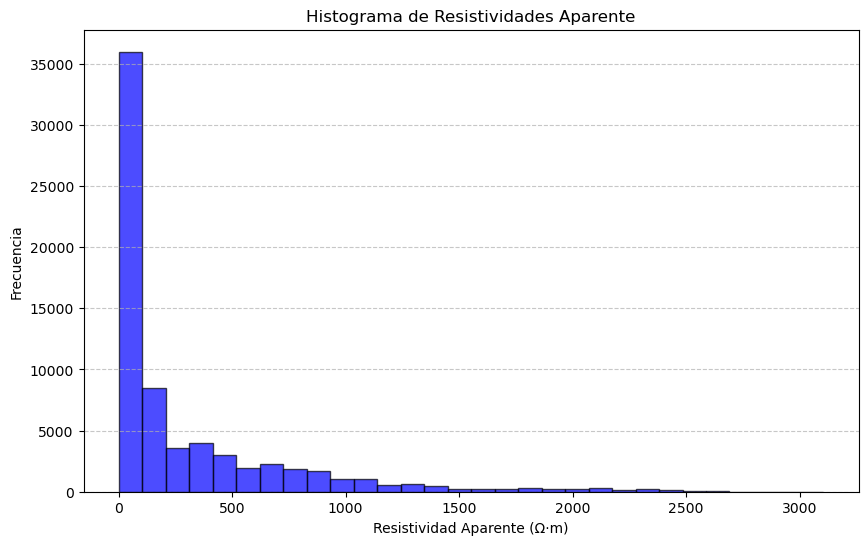

In [85]:
# Crear el histograma de resistividades aparentes
plt.figure(figsize=(10, 6))
plt.hist(resistividades_aparentes, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Resistividad Aparente (Ω·m)")
plt.ylabel("Frecuencia")
plt.title("Histograma de Resistividades Aparente")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

## paso 4

Con este conjunto de datos se procede a realizar el entrenamiento, usando los hiperparametyros para cada sitio calculados anteriormente, guardando el entrenamiento para cada sitio y comprobacion de cada sitio empleando los valores de adquisicion reales


Modelo entrenado correctamente.
Evaluación del Modelo para Sitio 8:
MAE (Error Absoluto Medio): 27.84
R² (Coeficiente de determinación): -0.09
Modelo guardado en modelo_sitio_8.joblib


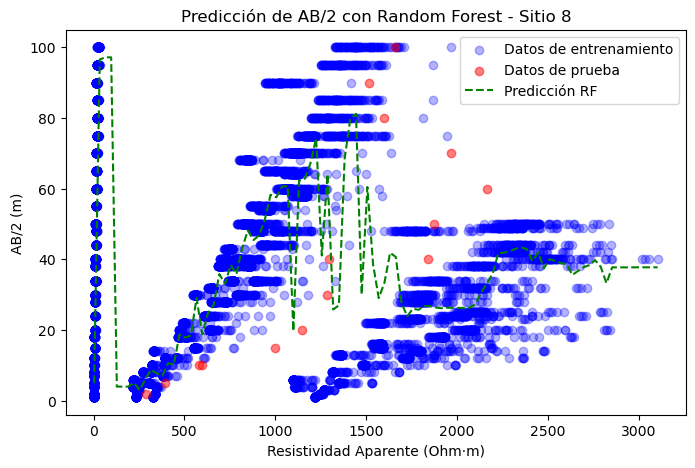

In [86]:

class RandomForestTrainer:
    """
    Clase de entremaniento Random Forest para un sitio especifico, el entrenamiento inclue las variaciones de cada uno de ellos 
    """

    def __init__(self, data_path: str, sitio_id: int):
        """ se inicia cargando los datos y filtrando por sitio.
        :param data_path: Ruta del archivo CSV con los datos.
        :param sitio_id: ID del sitio a entrenar. """
        self.data_path = data_path
        self.sitio_id = sitio_id
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = self.load_and_prepare_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.load_and_prepare_data(test_data_path="datos_prueba.csv")

    def load_and_prepare_data(self, test_data_path=None):
        """
        Carga y prepara los datos para entrenamiento y prueba.
        
        Parámetros:
            test_data_path (str, opcional): Ruta a un archivo CSV con datos de prueba.

        Retorna:
            X_train, X_test, y_train, y_test: Datos de entrada y salida divididos.
        """
        # Cargar datos de entrenamiento
        df = pd.read_csv(self.data_path)

        # Verificar si el sitio está en los datos
        if self.sitio_id not in df["Sitio_ID"].unique():
            raise ValueError(f"El sitio {self.sitio_id} no se encuentra en los datos.")

        # Filtrar por sitio
        df = df[df["Sitio_ID"] == self.sitio_id].copy()

        # Convertir tipos de datos
        df["Modelo_ID"] = df["Modelo_ID"].astype("category")
        df["AB2"] = df["AB2"].astype(np.float32)
        df["Resistividad_Aparente"] = df["Resistividad_Aparente"].astype(np.float32)

        # Definir variables de entrada y salida
        X = df[['Resistividad_Aparente']]
        y = df['AB2']
        groups = df["Modelo_ID"]

        # Si hay un archivo de prueba, cargarlo
        if test_data_path:
            df_test = pd.read_csv(test_data_path)

            # Filtrar por sitio si existe en los datos de prueba
            if self.sitio_id not in df_test["Sitio_ID"].unique():
                raise ValueError(f"El sitio {self.sitio_id} no se encuentra en los datos de prueba.")

            df_test = df_test[df_test["Sitio_ID"] == self.sitio_id].copy()

            # Convertir tipos de datos en datos de prueba
            df_test["AB2"] = df_test["AB2"].astype(np.float32)
            df_test["Resistividad_Aparente"] = df_test["Resistividad_Aparente"].astype(np.float32)

            # Definir variables de entrada y salida para prueba
            X_test = df_test[['Resistividad_Aparente']]
            y_test = df_test['AB2']

            # Usar todos los datos de entrenamiento
            X_train, y_train = X, y

        else:
            # Si no hay datos de prueba, dividir los datos de entrenamiento
            gss = GroupShuffleSplit(n_splits=1, test_size=0.09, random_state=42)
            train_idx, test_idx = next(gss.split(X, y, groups))
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        return X_train, X_test, y_train, y_test


    def train_model(self, n_estimators=200, max_depth=10, random_state=42):
        """
        Entrena un modelo Random Forest con los parámetros especificados.

        :param n_estimators: Número de árboles en el bosque.
        :param max_depth: Profundidad máxima del árbol.
        :param random_state: Semilla para reproducibilidad.
        """
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=random_state
        )
        self.model.fit(self.X_train, self.y_train)
        print("Modelo entrenado correctamente.")

    def evaluate_model(self):
        """
        Evalúa el modelo utilizando MAE y R².
        """
        if self.model is None:
            raise ValueError("El modelo aún no ha sido entrenado.")

        y_pred = self.model.predict(self.X_test)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print(f"Evaluación del Modelo para Sitio {self.sitio_id}:")
        print(f"MAE (Error Absoluto Medio): {mae:.2f}")
        print(f"R² (Coeficiente de determinación): {r2:.2f}")

        return mae, r2

    def save_model(self, file_path: Optional[str] = None):
        """
        Guarda el modelo entrenado en un archivo.

        :param file_path: Ruta del archivo donde se guardará el modelo.
        """
        if self.model is None:
            raise ValueError("No se puede guardar modelo no entrenado.")

        file_path = file_path or f"modelo_sitio_{self.sitio_id}.joblib"
        joblib.dump(self.model, file_path)
        print(f"Modelo guardado en {file_path}")

    def plot_results(self):
        """
        Grafica la relación entre la resistividad aparente y AB/2 junto con la predicción del modelo.
        """
        if self.model is None:
            raise ValueError("No se puede graficar un modelo no entrenado.")

        X_pred = pd.DataFrame(
            np.linspace(self.X_train['Resistividad_Aparente'].min(),
                        self.X_train['Resistividad_Aparente'].max(), 100),
            columns=["Resistividad_Aparente"]  
        )

        y_predicted = self.model.predict(X_pred)

        plt.figure(figsize=(8, 5))
        plt.scatter(self.X_train, self.y_train, label="Datos de entrenamiento", color="blue", alpha=0.3)
        plt.scatter(self.X_test, self.y_test, label="Datos de prueba", color="red", alpha=0.5)
        plt.plot(X_pred, y_predicted, label="Predicción RF", color="green", linestyle="dashed")
        plt.xlabel("Resistividad Aparente (Ohm·m)")
        plt.ylabel("AB/2 (m)")
        plt.title(f"Predicción de AB/2 con Random Forest - Sitio {self.sitio_id}")
        plt.legend()
        plt.show()


#ejecutamoss 
if __name__ == "__main__":
    sitio_especifico = 8  # seleccionamos el sitio especifico para el entrenamineto
    entrenador = RandomForestTrainer("RESULTADOS-Simulacion-Tesis-3.csv", sitio_especifico) ## Cargar el dataset en el que se encuentra el sitio
    entrenador.train_model(n_estimators=200, max_depth=10, random_state=42) #entrenamiento , aqui ponemos los hiperparametros que se obtubieron
    entrenador.evaluate_model()    #Evaluemos
    entrenador.save_model()    #realizamos el guardado de modelo empleando la libreria joblib \WorkWorkWork\modelo_sitio_8.joblib
    entrenador.plot_results()    #presentacion de resultados


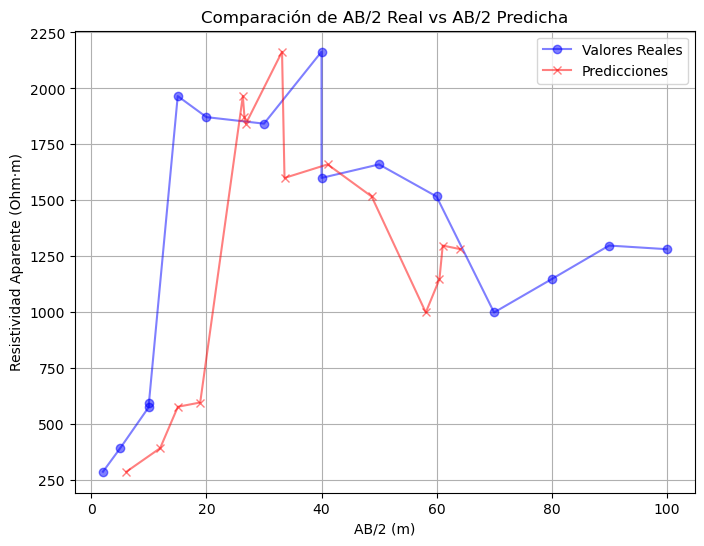

             Modelo_ID  Sitio_ID  Resistividad_Aparente  AB2  AB2_Predicho
0   S2-ZR-PEBSA-Prueba         8                  287.7    2      6.070797
1   S2-ZR-PEBSA-Prueba         8                  392.9    5     11.943737
3   S2-ZR-PEBSA-Prueba         8                  577.8   10     15.021429
2   S2-ZR-PEBSA-Prueba         8                  596.9   10     18.907738
11  S2-ZR-PEBSA-Prueba         8                 1965.6   70     26.319942
..                 ...       ...                    ...  ...           ...
13  S2-ZR-PEBSA-Prueba         8                 1517.1   90     48.718726
4   S2-ZR-PEBSA-Prueba         8                  999.1   15     58.131544
5   S2-ZR-PEBSA-Prueba         8                 1147.8   20     60.504251
7   S2-ZR-PEBSA-Prueba         8                 1298.0   40     61.075750
6   S2-ZR-PEBSA-Prueba         8                 1281.8   30     64.150820

[15 rows x 5 columns]


In [119]:

datos_prueba_path = "datos_prueba.csv"
modelo_path = "modelo_sitio_8.joblib"

modelo = joblib.load(modelo_path)
df_prueba1 = pd.read_csv(datos_prueba_path)
df_prueba = pd.read_csv(datos_prueba_path)

# Definir variable de entrada
X_prueba = df_prueba[['Resistividad_Aparente']]

# Hacer predicción
df_prueba["AB2_Predicho"] = modelo.predict(X_prueba)

# Guardar los resultados en un archivo CSV
output_path = "predicciones_sitio_8.csv"
df_prueba.to_csv(output_path, index=False)

# **Ordenar los datos de menor a mayor según AB2**
df_prueba = df_prueba.sort_values(by="AB2_Predicho")

# **Invertir los ejes en el gráfico**
plt.figure(figsize=(8, 6))
plt.plot(df_prueba1["AB2"], df_prueba["Resistividad_Aparente"], "bo-", alpha=0.5, label="Valores Reales")
plt.plot(df_prueba["AB2_Predicho"], df_prueba["Resistividad_Aparente"], "rx-", alpha=0.5, label="Predicciones")

# Etiquetas y título
plt.xlabel("AB/2 (m)")
plt.ylabel("Resistividad Aparente (Ohm·m)")
plt.title("Comparación de AB/2 Real vs AB/2 Predicha")
plt.legend()
plt.grid(True)
#plt.yscale("log")
plt.show()

# Mostrar los resultados
print(df_prueba[["Modelo_ID", "Sitio_ID", "Resistividad_Aparente", "AB2", "AB2_Predicho"]])


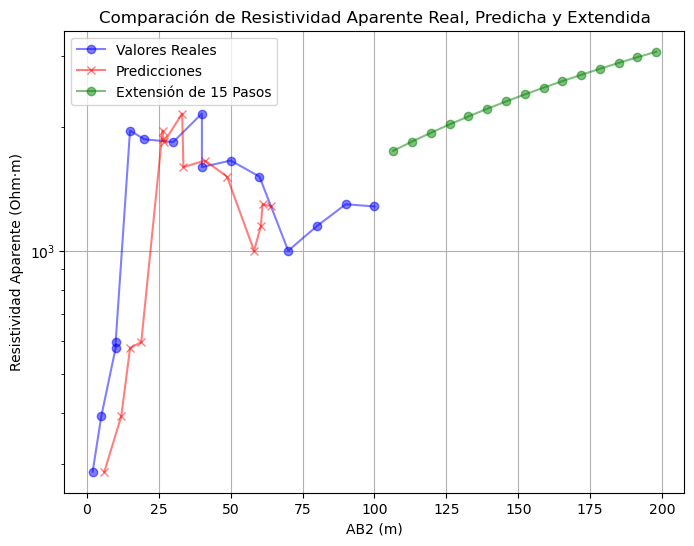

             Modelo_ID  Sitio_ID  Resistividad_Aparente  AB2  AB2_Predicho
0   S2-ZR-PEBSA-Prueba         8                  287.7    2      6.070797
1   S2-ZR-PEBSA-Prueba         8                  392.9    5     11.943737
3   S2-ZR-PEBSA-Prueba         8                  577.8   10     15.021429
2   S2-ZR-PEBSA-Prueba         8                  596.9   10     18.907738
11  S2-ZR-PEBSA-Prueba         8                 1965.6   70     26.319942
..                 ...       ...                    ...  ...           ...
13  S2-ZR-PEBSA-Prueba         8                 1517.1   90     48.718726
4   S2-ZR-PEBSA-Prueba         8                  999.1   15     58.131544
5   S2-ZR-PEBSA-Prueba         8                 1147.8   20     60.504251
7   S2-ZR-PEBSA-Prueba         8                 1298.0   40     61.075750
6   S2-ZR-PEBSA-Prueba         8                 1281.8   30     64.150820

[15 rows x 5 columns]


In [117]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Cargar los datos y el modelo
datos_prueba_path = "datos_prueba.csv"
modelo_path = "modelo_sitio_8.joblib"

modelo = joblib.load(modelo_path)
df_prueba1 = pd.read_csv(datos_prueba_path)
df_prueba = pd.read_csv(datos_prueba_path)

# Definir variable de entrada
X_prueba = df_prueba[['Resistividad_Aparente']]

# Hacer predicción
df_prueba["AB2_Predicho"] = modelo.predict(X_prueba)

# **Extender la predicción en 15 pasos más en AB2**
max_AB2 = df_prueba["AB2"].max()
incremento = (df_prueba["AB2"].max() - df_prueba["AB2"].min()) / len(df_prueba)
AB2_extendido = [max_AB2 + (i + 1) * incremento for i in range(15)]

# **Interpolar o estimar valores de "Resistividad_Aparente" para los nuevos AB2**
interp_func = interp1d(df_prueba["AB2"], df_prueba["Resistividad_Aparente"], fill_value="extrapolate")
Resistividad_extendida = interp_func(AB2_extendido)

# Crear DataFrame con los nuevos valores extendidos
df_extendido = pd.DataFrame({"AB2": AB2_extendido, "Resistividad_Aparente": Resistividad_extendida})

# Predecir AB2 para los valores extendidos de Resistividad
df_extendido["AB2_Predicho"] = modelo.predict(df_extendido[["Resistividad_Aparente"]])

# **Ordenar los datos de menor a mayor según AB2**
df_prueba = df_prueba.sort_values(by="AB2_Predicho")
df_extendido = df_extendido.sort_values(by="AB2")

# Guardar los resultados en un archivo CSV
output_path = "predicciones_sitio_8_extendido.csv"
df_prueba.to_csv(output_path, index=False)

# **Gráfico con valores reales, predicciones y extensión**
plt.figure(figsize=(8, 6))
plt.plot(df_prueba1["AB2"], df_prueba["Resistividad_Aparente"], "bo-", alpha=0.5, label="Valores Reales")
plt.plot(df_prueba["AB2_Predicho"], df_prueba["Resistividad_Aparente"], "rx-", alpha=0.5, label="Predicciones")
plt.plot(df_extendido["AB2"], df_extendido["Resistividad_Aparente"], "go-", alpha=0.5, label="Extensión de 15 Pasos")

# Etiquetas y título
plt.xlabel("AB2 (m)")
plt.ylabel("Resistividad Aparente (Ohm·m)")
plt.title("Comparación de Resistividad Aparente Real, Predicha y Extendida")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Mantener escala logarítmica

plt.show()

# Mostrar los resultados
print(df_prueba[["Modelo_ID", "Sitio_ID", "Resistividad_Aparente", "AB2", "AB2_Predicho"]])


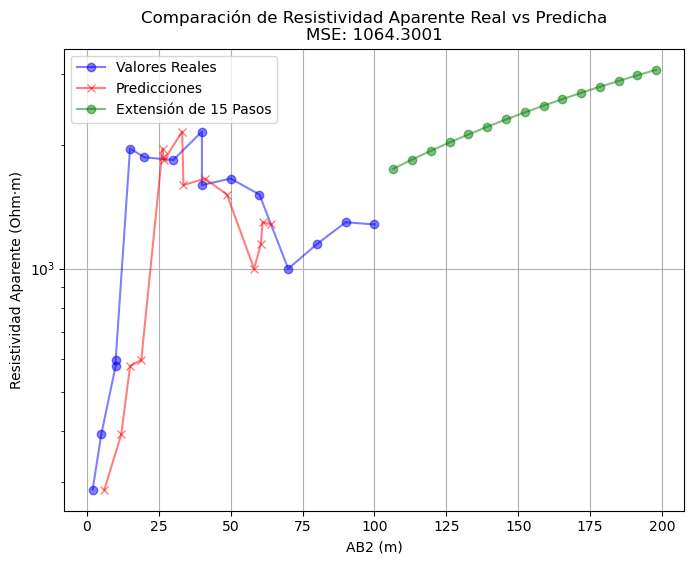

             Modelo_ID  Sitio_ID  Resistividad_Aparente  AB2  AB2_Predicho
0   S2-ZR-PEBSA-Prueba         8                  287.7    2      6.070797
1   S2-ZR-PEBSA-Prueba         8                  392.9    5     11.943737
3   S2-ZR-PEBSA-Prueba         8                  577.8   10     15.021429
2   S2-ZR-PEBSA-Prueba         8                  596.9   10     18.907738
11  S2-ZR-PEBSA-Prueba         8                 1965.6   70     26.319942
..                 ...       ...                    ...  ...           ...
13  S2-ZR-PEBSA-Prueba         8                 1517.1   90     48.718726
4   S2-ZR-PEBSA-Prueba         8                  999.1   15     58.131544
5   S2-ZR-PEBSA-Prueba         8                 1147.8   20     60.504251
7   S2-ZR-PEBSA-Prueba         8                 1298.0   40     61.075750
6   S2-ZR-PEBSA-Prueba         8                 1281.8   30     64.150820

[15 rows x 5 columns]


In [118]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

# Cargar los datos y el modelo
datos_prueba_path = "datos_prueba.csv"
modelo_path = "modelo_sitio_8.joblib"

modelo = joblib.load(modelo_path)
df_prueba1 = pd.read_csv(datos_prueba_path)
df_prueba = pd.read_csv(datos_prueba_path)

# Definir variable de entrada
X_prueba = df_prueba[['Resistividad_Aparente']]

# Hacer predicción
df_prueba["AB2_Predicho"] = modelo.predict(X_prueba)

# **Cálculo del Error Cuadrático Medio (MSE)**
mse = mean_squared_error(df_prueba["AB2"], df_prueba["AB2_Predicho"])

# **Extender la predicción en 15 pasos más en AB2**
max_AB2 = df_prueba["AB2"].max()
incremento = (df_prueba["AB2"].max() - df_prueba["AB2"].min()) / len(df_prueba)
AB2_extendido = [max_AB2 + (i + 1) * incremento for i in range(15)]

# **Interpolar o estimar valores de "Resistividad_Aparente" para los nuevos AB2**
interp_func = interp1d(df_prueba["AB2"], df_prueba["Resistividad_Aparente"], fill_value="extrapolate")
Resistividad_extendida = interp_func(AB2_extendido)

# Crear DataFrame con los nuevos valores extendidos
df_extendido = pd.DataFrame({"AB2": AB2_extendido, "Resistividad_Aparente": Resistividad_extendida})

# Predecir AB2 para los valores extendidos de Resistividad
df_extendido["AB2_Predicho"] = modelo.predict(df_extendido[["Resistividad_Aparente"]])

# **Ordenar los datos de menor a mayor según AB2**
df_prueba = df_prueba.sort_values(by="AB2_Predicho")
df_extendido = df_extendido.sort_values(by="AB2")

# Guardar los resultados en un archivo CSV
output_path = "predicciones_sitio_8_extendido.csv"
df_prueba.to_csv(output_path, index=False)

# **Gráfico con valores reales, predicciones y extensión**
plt.figure(figsize=(8, 6))
plt.plot(df_prueba1["AB2"], df_prueba["Resistividad_Aparente"], "bo-", alpha=0.5, label="Valores Reales")
plt.plot(df_prueba["AB2_Predicho"], df_prueba["Resistividad_Aparente"], "rx-", alpha=0.5, label="Predicciones")
plt.plot(df_extendido["AB2"], df_extendido["Resistividad_Aparente"], "go-", alpha=0.5, label="Extensión de 15 Pasos")

# Etiquetas y título
plt.xlabel("AB2 (m)")
plt.ylabel("Resistividad Aparente (Ohm·m)")
plt.title(f"Comparación de Resistividad Aparente Real vs Predicha\nMSE: {mse:.4f}")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Mantener escala logarítmica

plt.show()

# Mostrar los resultados
print(df_prueba[["Modelo_ID", "Sitio_ID", "Resistividad_Aparente", "AB2", "AB2_Predicho"]])


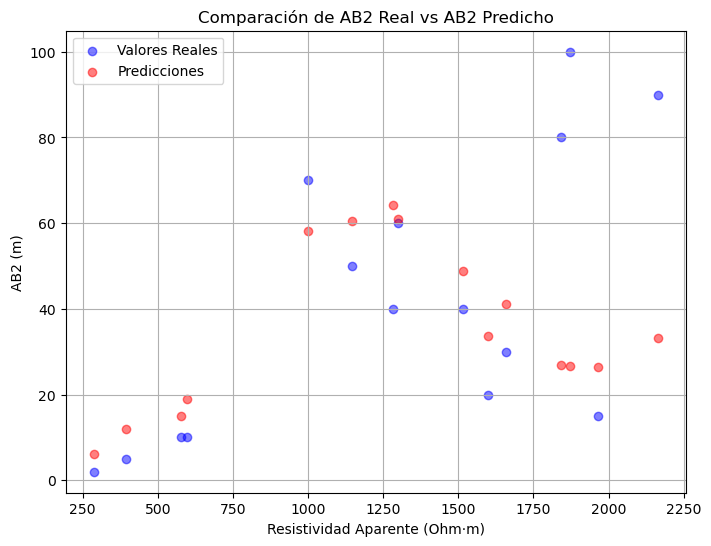

             Modelo_ID  Sitio_ID  Resistividad_Aparente  AB2  AB2_Predicho
0   S2-ZR-PEBSA-Prueba         8                  287.7    2      6.070797
1   S2-ZR-PEBSA-Prueba         8                  392.9    5     11.943737
3   S2-ZR-PEBSA-Prueba         8                  577.8   10     15.021429
2   S2-ZR-PEBSA-Prueba         8                  596.9   10     18.907738
11  S2-ZR-PEBSA-Prueba         8                 1965.6   70     26.319942
..                 ...       ...                    ...  ...           ...
13  S2-ZR-PEBSA-Prueba         8                 1517.1   90     48.718726
4   S2-ZR-PEBSA-Prueba         8                  999.1   15     58.131544
5   S2-ZR-PEBSA-Prueba         8                 1147.8   20     60.504251
7   S2-ZR-PEBSA-Prueba         8                 1298.0   40     61.075750
6   S2-ZR-PEBSA-Prueba         8                 1281.8   30     64.150820

[15 rows x 5 columns]


In [106]:
datos_prueba_path = "datos_prueba.csv"
modelo_path = "modelo_sitio_8.joblib"

modelo = joblib.load(modelo_path)
df_prueba1 = pd.read_csv(datos_prueba_path)
df_prueba = pd.read_csv(datos_prueba_path)


X_prueba = df_prueba[['Resistividad_Aparente']]

df_prueba["AB2_Predicho"] = modelo.predict(X_prueba)

# Guardar los resultados en un nuevo archivo
output_path = "predicciones_sitio_8.csv"
df_prueba.to_csv(output_path, index=False)

df_prueba = df_prueba.sort_values(by="AB2_Predicho")


plt.figure(figsize=(8, 6))
plt.scatter(df_prueba1["Resistividad_Aparente"], df_prueba["AB2"], color="blue", alpha=0.5, label="Valores Reales")
plt.scatter(df_prueba["Resistividad_Aparente"], df_prueba["AB2_Predicho"], color="red", alpha=0.5, label="Predicciones")
plt.xlabel("Resistividad Aparente (Ohm·m)")
plt.ylabel("AB2 (m)")
plt.title("Comparación de AB2 Real vs AB2 Predicho")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados
print(df_prueba[["Modelo_ID", "Sitio_ID", "Resistividad_Aparente", "AB2", "AB2_Predicho"]])

Modelo entrenado correctamente.
Evaluación del Modelo para Sitio 8:
MAE (Error Absoluto Medio): 18.45
R² (Coeficiente de determinación): 0.29
Modelo guardado en modeloCompleto_sitio_8.joblib


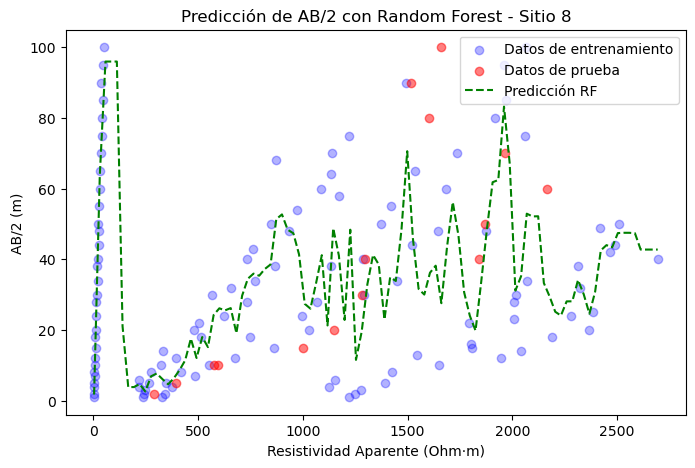

In [88]:
class RandomForestTrainer:
    """
    Clase de entremaniento Random Forest para un sitio especifico, el entrenamiento inclue las variaciones de cada uno de ellos 
    """

    def __init__(self, data_path: str, sitio_id: int):
        """ se inicia cargando los datos y filtrando por sitio.
        :param data_path: Ruta del archivo CSV con los datos.
        :param sitio_id: ID del sitio a entrenar. """
        self.data_path = data_path
        self.sitio_id = sitio_id
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = self.load_and_prepare_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.load_and_prepare_data(test_data_path="datos_prueba.csv")

    def load_and_prepare_data(self, test_data_path=None):
        """
        Carga y prepara los datos para entrenamiento y prueba.
        
        Parámetros:
            test_data_path (str, opcional): Ruta a un archivo CSV con datos de prueba.

        Retorna:
            X_train, X_test, y_train, y_test: Datos de entrada y salida divididos.
        """
        # Cargar datos de entrenamiento
        df = pd.read_csv(self.data_path)

        # Verificar si el sitio está en los datos
        if self.sitio_id not in df["Sitio_ID"].unique():
            raise ValueError(f"El sitio {self.sitio_id} no se encuentra en los datos.")

        # Filtrar por sitio
        df = df[df["Sitio_ID"] == self.sitio_id].copy()

        # Convertir tipos de datos
        df["Modelo_ID"] = df["Modelo_ID"].astype("category")
        df["AB2"] = df["AB2"].astype(np.float32)
        df["Resistividad_Aparente"] = df["Resistividad_Aparente"].astype(np.float32)

        # Definir variables de entrada y salida
        X = df[['Resistividad_Aparente']]
        y = df['AB2']
        groups = df["Modelo_ID"]

        # Si hay un archivo de prueba, cargarlo
        if test_data_path:
            df_test = pd.read_csv(test_data_path)

            # Filtrar por sitio si existe en los datos de prueba
            if self.sitio_id not in df_test["Sitio_ID"].unique():
                raise ValueError(f"El sitio {self.sitio_id} no se encuentra en los datos de prueba.")

            df_test = df_test[df_test["Sitio_ID"] == self.sitio_id].copy()

            # Convertir tipos de datos en datos de prueba
            df_test["AB2"] = df_test["AB2"].astype(np.float32)
            df_test["Resistividad_Aparente"] = df_test["Resistividad_Aparente"].astype(np.float32)

            # Definir variables de entrada y salida para prueba
            X_test = df_test[['Resistividad_Aparente']]
            y_test = df_test['AB2']

            # Usar todos los datos de entrenamiento
            X_train, y_train = X, y

        else:
            # Si no hay datos de prueba, dividir los datos de entrenamiento
            gss = GroupShuffleSplit(n_splits=1, test_size=0.09, random_state=42)
            train_idx, test_idx = next(gss.split(X, y, groups))
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        return X_train, X_test, y_train, y_test


    def train_model(self, n_estimators=200, max_depth=10, random_state=42):
        """
        Entrena un modelo Random Forest con los parámetros especificados.

        :param n_estimators: Número de árboles en el bosque.
        :param max_depth: Profundidad máxima del árbol.
        :param random_state: Semilla para reproducibilidad.
        """
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=random_state
        )
        self.model.fit(self.X_train, self.y_train)
        print("Modelo entrenado correctamente.")

    def evaluate_model(self):
        """
        Evalúa el modelo utilizando MAE y R².
        """
        if self.model is None:
            raise ValueError("El modelo aún no ha sido entrenado.")

        y_pred = self.model.predict(self.X_test)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print(f"Evaluación del Modelo para Sitio {self.sitio_id}:")
        print(f"MAE (Error Absoluto Medio): {mae:.2f}")
        print(f"R² (Coeficiente de determinación): {r2:.2f}")

        return mae, r2

    def save_model(self, file_path: Optional[str] = None):
        """
        Guarda el modelo entrenado en un archivo.

        :param file_path: Ruta del archivo donde se guardará el modelo.
        """
        if self.model is None:
            raise ValueError("No se puede guardar modelo no entrenado.")

        file_path = file_path or f"modeloCompleto_sitio_{self.sitio_id}.joblib"
        joblib.dump(self.model, file_path)
        print(f"Modelo guardado en {file_path}")

    def plot_results(self):
        """
        Grafica la relación entre la resistividad aparente y AB/2 junto con la predicción del modelo.
        """
        if self.model is None:
            raise ValueError("No se puede graficar un modelo no entrenado.")

        X_pred = pd.DataFrame(
            np.linspace(self.X_train['Resistividad_Aparente'].min(),
                        self.X_train['Resistividad_Aparente'].max(), 100),
            columns=["Resistividad_Aparente"]  
        )

        y_predicted = self.model.predict(X_pred)

        plt.figure(figsize=(8, 5))
        plt.scatter(self.X_train, self.y_train, label="Datos de entrenamiento", color="blue", alpha=0.3)
        plt.scatter(self.X_test, self.y_test, label="Datos de prueba", color="red", alpha=0.5)
        plt.plot(X_pred, y_predicted, label="Predicción RF", color="green", linestyle="dashed")
        plt.xlabel("Resistividad Aparente (Ohm·m)")
        plt.ylabel("AB/2 (m)")
        plt.title(f"Predicción de AB/2 con Random Forest - Sitio {self.sitio_id}")
        plt.legend()
        plt.show()


#ejecutamoss 
if __name__ == "__main__":
    sitio_especifico = 8  # seleccionamos el sitio especifico para el entrenamineto
    entrenador = RandomForestTrainer("RESULTADOS-Simulacion-Tesis-2.csv", sitio_especifico) ## Cargar el dataset en el que se encuentra el sitio
    entrenador.train_model(n_estimators=100, max_depth=10, random_state=42) #entrenamiento , aqui ponemos los hiperparametros que se obtubieron
    entrenador.evaluate_model()    #Evaluemos
    entrenador.save_model()    #realizamos el guardado de modelo empleando la libreria joblib \WorkWorkWork\modelo_sitio_8.joblib
    entrenador.plot_results()    #presentacion de resultados

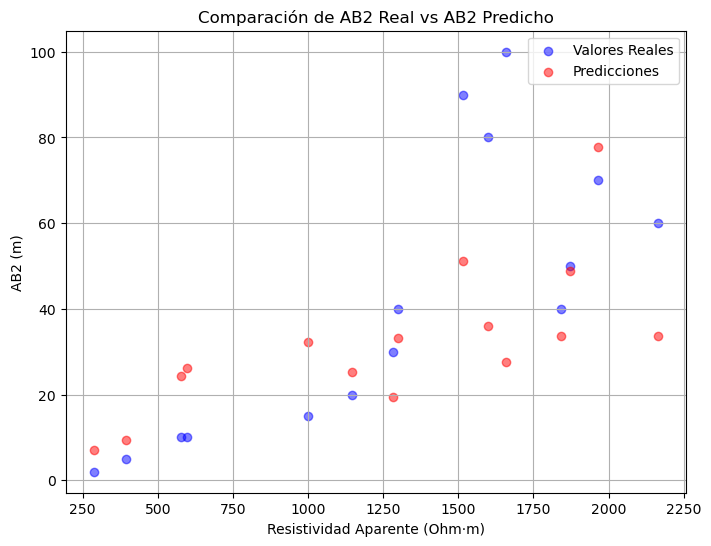

             Modelo_ID  Sitio_ID  Resistividad_Aparente  AB2  AB2_Predicho
0   S2-ZR-PEBSA-Prueba         8                  287.7    2      7.170000
1   S2-ZR-PEBSA-Prueba         8                  392.9    5      9.310000
2   S2-ZR-PEBSA-Prueba         8                  596.9   10     26.148460
3   S2-ZR-PEBSA-Prueba         8                  577.8   10     24.263291
4   S2-ZR-PEBSA-Prueba         8                  999.1   15     32.366815
..                 ...       ...                    ...  ...           ...
10  S2-ZR-PEBSA-Prueba         8                 2163.8   60     33.591217
11  S2-ZR-PEBSA-Prueba         8                 1965.6   70     77.879662
12  S2-ZR-PEBSA-Prueba         8                 1600.0   80     36.052140
13  S2-ZR-PEBSA-Prueba         8                 1517.1   90     51.233423
14  S2-ZR-PEBSA-Prueba         8                 1660.4  100     27.596271

[15 rows x 5 columns]


In [ ]:
datos_prueba_path = "datos_prueba.csv"
modelo_path = "modeloCompleto_sitio_8.joblib"

modelo = joblib.load(modelo_path)
df_prueba1 = pd.read_csv(datos_prueba_path)
df_prueba = pd.read_csv(datos_prueba_path)


X_prueba = df_prueba[['Resistividad_Aparente']]

df_prueba["AB2_Predicho"] = modelo.predict(X_prueba)

# Guardar los resultados en un nuevo archivo
output_path = "predicciones_sitio_8.csv"
df_prueba.to_csv(output_path, index=False)

plt.figure(figsize=(8, 6))
plt.scatter(df_prueba1["Resistividad_Aparente"], df_prueba["AB2"], color="blue", alpha=0.5, label="Valores Reales")
plt.scatter(df_prueba["Resistividad_Aparente"], df_prueba["AB2_Predicho"], color="red", alpha=0.5, label="Predicciones")
plt.xlabel("Resistividad Aparente (Ohm·m)")
plt.ylabel("AB2 (m)")
plt.title("Comparación de AB2 Real vs AB2 Predicho")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados
print(df_prueba[["Modelo_ID", "Sitio_ID", "Resistividad_Aparente", "AB2", "AB2_Predicho"]])


🔍 Buscando mejores hiperparámetros para Sitio 8...

✅ Sitio 8 - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 100}

MAE (Error Absoluto Medio): 68.95
R² (Coeficiente de determinación): -0.05


c:\Users\juanj\.conda\envs\pg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


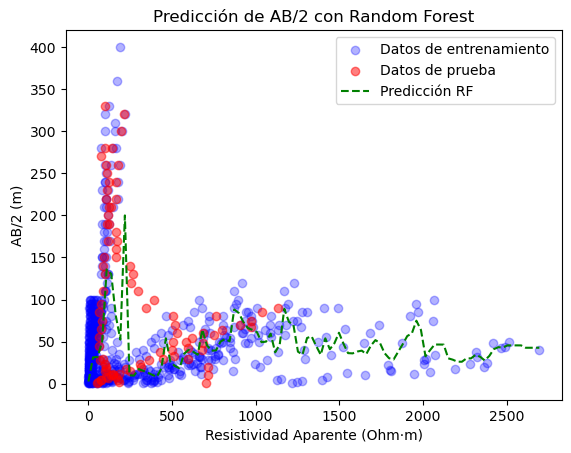

In [94]:
#datos de entrada
#df = pd.read_csv("Simulacion-Rha-sintetica-Tesina-MCD-.csv")  

df = pd.read_csv("RESULTADOS-Simulacion-Tesis-2.csv")  

df["Modelo_ID"] = df["Modelo_ID"].astype("category")
df["AB2"] = df["AB2"].astype(np.float32)
df["Resistividad_Aparente"] = df["Resistividad_Aparente"].astype(np.float32)

# LA VARIABLE DE ENTRADA ES LA RESISTIVIDAD APARENTE mientras que la variable objetivo es AB/2
X = df[['Resistividad_Aparente']]  
y = df['AB2'] 
groups = df["Modelo_ID"]

# dividimos por grupos para entrenamiento y prueba
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# modelo de entrenamiento, consideramos 500 arboles y una profundidad de 10 y na semilla de 42 y comparacmos con variacione de ramas y max_depth
rf_inverse = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)
rf_inverse.fit(X_train, y_train)

#evalucion delk modelo empoleado el error absoluto medio y el coeficiente de determinacion
y_pred = rf_inverse.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.2f}")


X_pred = np.linspace(min(X_train['Resistividad_Aparente']), max(X_train['Resistividad_Aparente']), 100).reshape(-1, 1)
y_predicted = rf_inverse.predict(X_pred)

plt.scatter(X_train, y_train, label="Datos de entrenamiento", color="blue", alpha=0.3)
plt.scatter(X_test, y_test, label="Datos de prueba", color="red", alpha=0.5)
plt.plot(X_pred, y_predicted, label="Predicción RF", color="green", linestyle="dashed")
plt.xlabel("Resistividad Aparente (Ohm·m)")
plt.ylabel("AB/2 (m)")
plt.title("Predicción de AB/2 con Random Forest")
plt.legend()
plt.show()
